<a href="https://colab.research.google.com/github/matthiasweidlich/conf_tutorial/blob/master/Conformance_Checking_Chapter_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conformance Checking Chapter 7**
---

### Notebook preliminaries (pip installs, git cloning, imports, ...)

In [ ]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
!git clone https://github.com/matthiasweidlich/conf_tutorial.git

In [ ]:
!pip install pmlab-lite

In [2]:
from pmlab_lite.pn import PetriNet, TraceNet, SynchronousProduct
from pmlab_lite.helper.io import pnml 
from pmlab_lite.helper.viz import dot
from pmlab_lite.alignments.a_star import A_Star

## Aligning Event Data and Process Models
---

In [3]:
running_example = PetriNet()
pnml.load(running_example, '/content/conf_tutorial/running_example.pnml') # path when using the colab button
#pnml.load(running_example, './running_example.pnml')                     # path for local execution

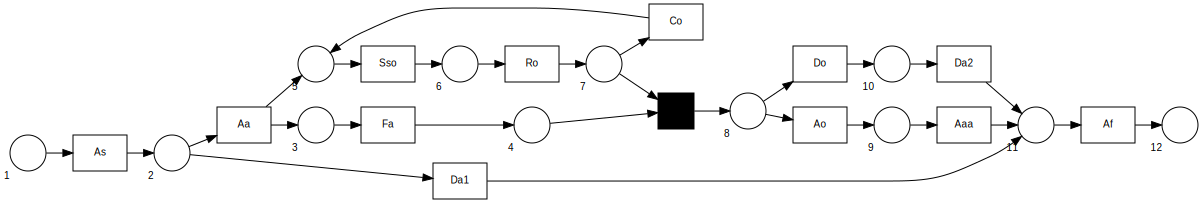

In [4]:
dot.draw_petri_net(running_example)

### Computing Optimal Alignments

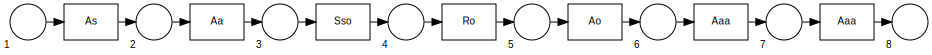

In [16]:
trace = ['As', 'Aa', 'Sso', 'Ro', 'Ao', 'Aaa', 'Aaa']
trace_net = TraceNet(trace)
dot.draw_petri_net(trace_net)

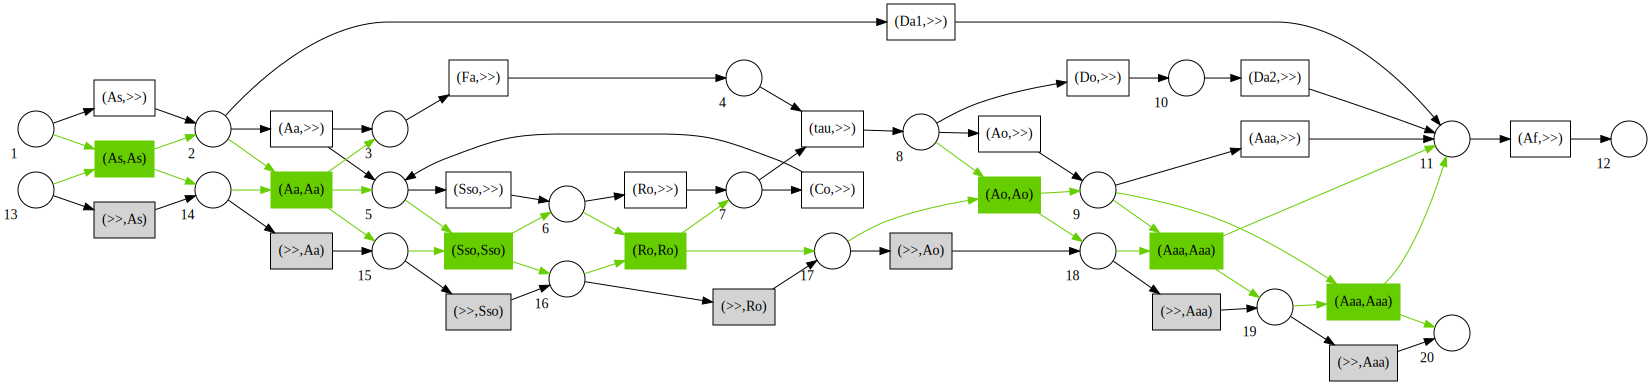

In [17]:
sp = SynchronousProduct(running_example, trace_net)
dot.draw_synchronous_product(sp)

In [18]:
trace_length_searcher1 = A_Star(sp, trace, heuristic='tl')
trace_length_searcher1.search()

In [19]:
ilp_searcher1 = A_Star(sp, trace, heuristic='lp')
ilp_searcher1.search()

Compare the alignments found by the trace length and the integer linear programming heuristics

In [22]:
print('Optimal Alignment found using the trace length heuristic:')
trace_length_searcher1.print_alignment()
print()
print('Optimal Alignment found using the ilp heuristic:')
ilp_searcher1.print_alignment() 

Optimal Alignment found using the trace length heuristic:
----------------------------------------------------------------------------
| log trace          | As | Aa | Sso | Ro | >> | >>  | Ao | Aaa | Aaa | >> |
----------------------------------------------------------------------------
| execution sequence | As | Aa | Sso | Ro | Fa | tau | Ao | Aaa | >>  | Af |
----------------------------------------------------------------------------

Optimal Alignment found using the ilp heuristic:
----------------------------------------------------------------------------
| log trace          | As | Aa | >> | Sso | Ro | >>  | Ao | Aaa | Aaa | >> |
----------------------------------------------------------------------------
| execution sequence | As | Aa | Fa | Sso | Ro | tau | Ao | >>  | Aaa | Af |
----------------------------------------------------------------------------


As well the corresponding search spaces spanned while traversing the graph for a solution

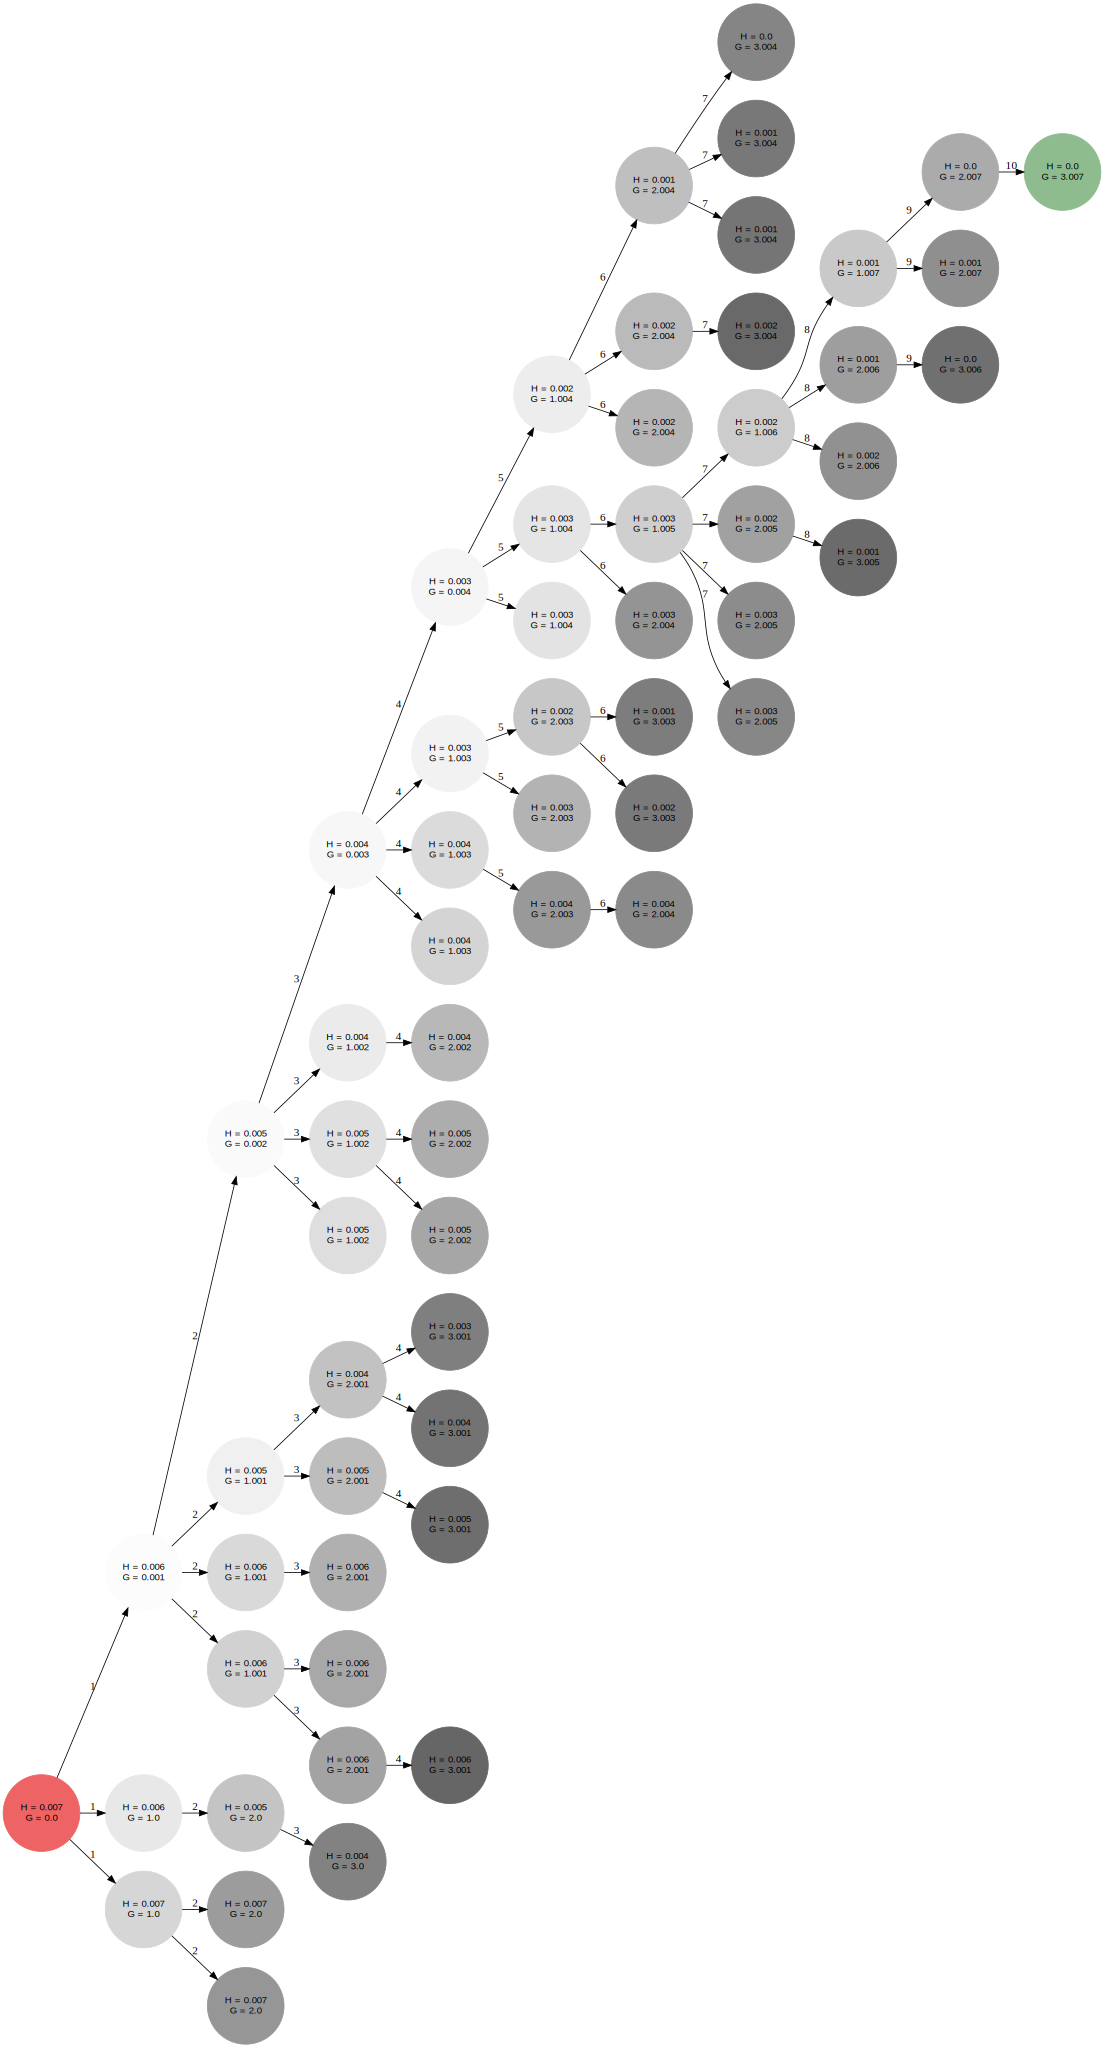

In [23]:
dot.draw_a_star_search_space(trace_length_searcher1)

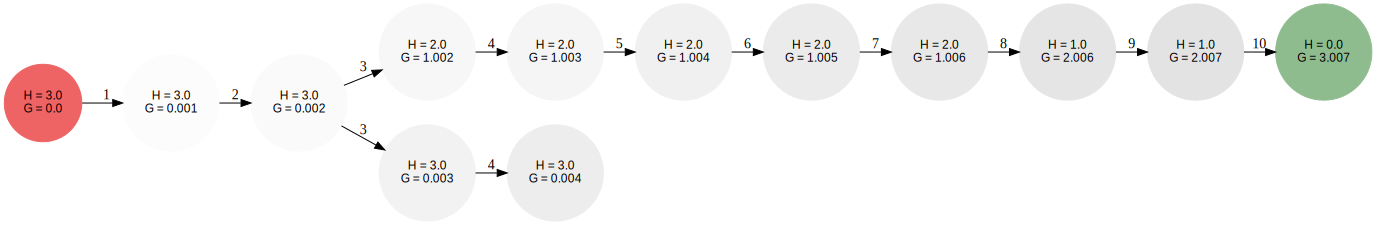

In [24]:
dot.draw_a_star_search_space(ilp_searcher1)

*Describe* the differences you observe in the two search spaces shown above. <br>
Furthermore *explain* why these differences occur. <br>
(Additionally *measure* the respective runtimes of the search funtions using python.)

### Another example

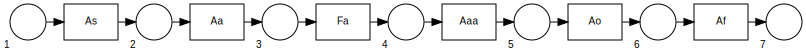

In [5]:
trace2 = ['As', 'Aa', 'Fa', 'Aaa', 'Ao', 'Af']
trace_net2 = TraceNet(trace)
dot.draw_petri_net(trace_net2)

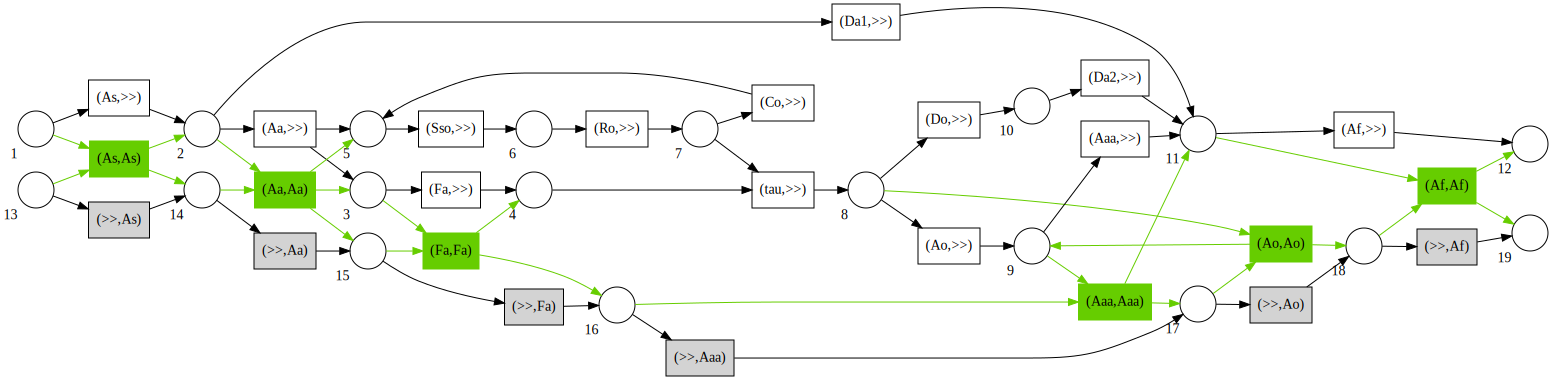

In [6]:
sp = SynchronousProduct(running_example, trace_net2)
dot.draw_synchronous_product(sp)

In [25]:
ilp_searcher2 = A_Star(sp, trace2, heuristic='lp')
ilp_searcher2.search()

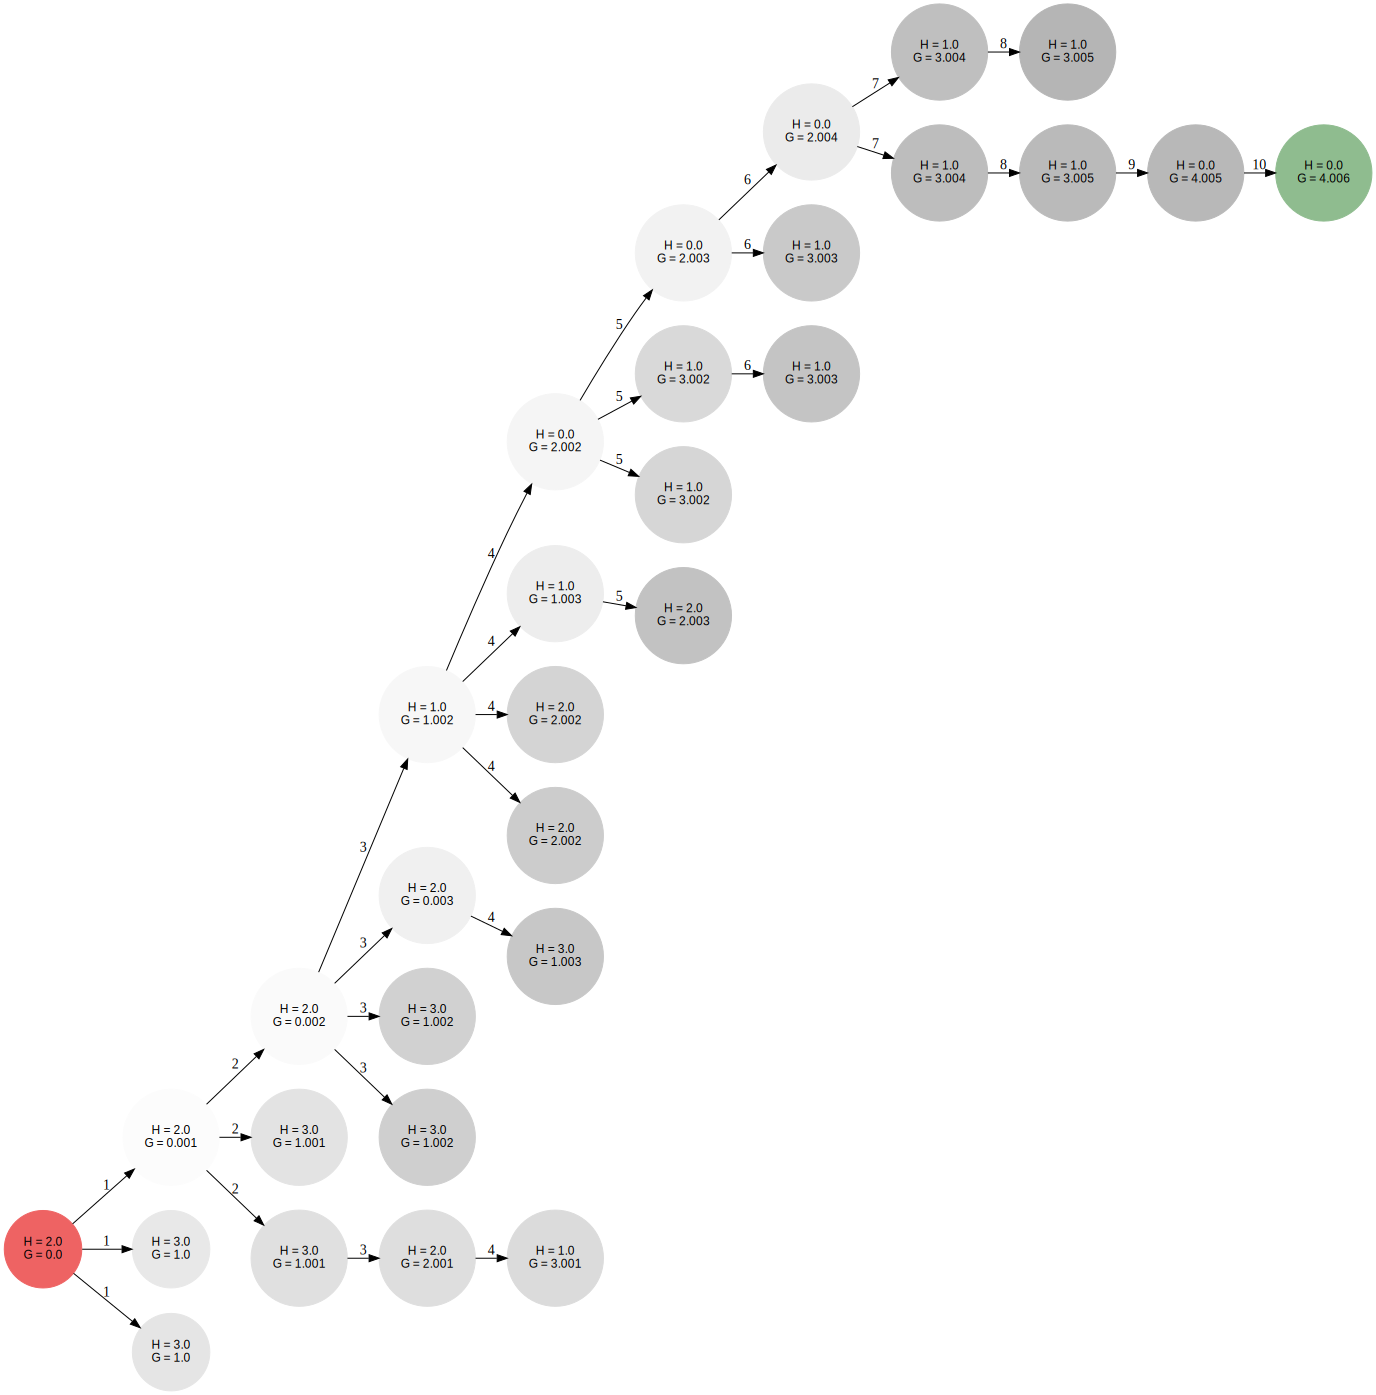

In [27]:
dot.draw_a_star_search_space(ilp_heuristic_searcher2)